In [41]:
# Import packages needed for Part 2
import os
import sqlite3
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [42]:
# Set working directory containing the Harvard Dataverse files
os.chdir('/Users/wjc1/Desktop/Programming for data science/ST2195 Coursework/Cw datasets')
os.getcwd()

'/Users/wjc1/Desktop/Programming for data science/ST2195 Coursework/Cw datasets'

In [43]:
# Remove the database if it already exists and connect to the new database named "airline_v2.db"
try: 
    os.remove("airline_v2.db")
except OSError:
    pass
conn = sqlite3.connect("airline_v2.db")

In [44]:
# Creating tables in the database
airports = pd.read_csv("airports.csv")
carriers = pd.read_csv("carriers.csv")
planes = pd.read_csv("plane-data.csv")

airports.to_sql("airports", conn, index=False, if_exists='replace')
carriers.to_sql("carriers", conn, index = False, if_exists='replace')
planes.to_sql("planes", conn, index = False, if_exists='replace')

5029

In [45]:
# Read and write CSV files containing 5 years of data into one database table
dfs = []
for year in range(2004, 2009):
    filename = f"{year}.csv.bz2"
    # Read CSV files in chunks
    chunks = pd.read_csv(filename, encoding="latin-1", compression="bz2", chunksize=10000)
    for chunk in chunks:
        dfs.append(chunk)
    print(f"{filename} completed")
ontime = pd.concat(dfs, ignore_index=True)

2004.csv.bz2 completed
2005.csv.bz2 completed
2006.csv.bz2 completed
2007.csv.bz2 completed
2008.csv.bz2 completed


Part 2(a): Best times and days of the week to minimise delays each year

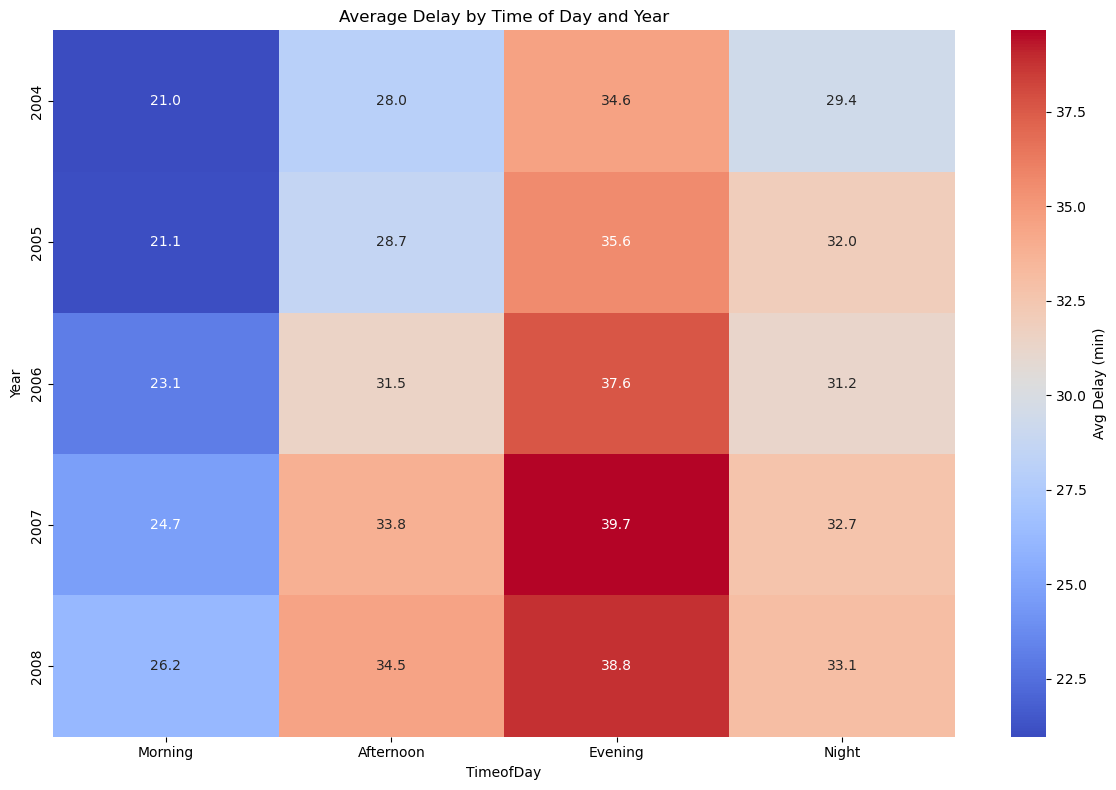

In [47]:
# Delays Table
Delays = ontime

# Day Segmentation Function
def find_time(CRSDepTime):
    if CRSDepTime in range(500, 1200):
        return "Morning"
    elif CRSDepTime in range(1200, 1700):
        return "Afternoon"
    elif CRSDepTime in range(1700, 2100):
        return "Evening"
    else:
        return "Night"

# Apply the find_time function to create the 'TimeofDay' variable
TimeofDay_list =[]
for CRSDepTime in Delays['CRSDepTime']:
    TimeofDay = find_time(CRSDepTime)
    TimeofDay_list.append(TimeofDay)
Delays['TimeofDay'] = TimeofDay_list

# Day of Week Function
def find_day(DayOfWeek):
    Day = {
        1:'Monday', 2:'Tuesday', 3:'Wednesday',
        4:'Thursday', 5:'Friday', 6:'Saturday',
        7:'Sunday'}
    return Day.get(DayOfWeek)

# Apply the find_day function to create the 'Day' variable
Day_list = []
for DayOfWeek in Delays['DayOfWeek']:
    Day = find_day(DayOfWeek)
    Day_list.append(Day)
Delays['Day'] = Day_list

# Function to filter out the negative ArrDelay values
def delayed(ArrDelay):
    if ArrDelay > 0:
        return ArrDelay

Delayed_list = []
for ArrDelay in Delays['ArrDelay']:
    Delay = delayed(ArrDelay)
    Delayed_list.append(Delay)
    
Delays['arrdelay'] = Delayed_list

# Ensure column names are correct and consistent before proceeding with aggregation
# Check if 'arrdelay' column exists, if not, recreate it
if 'arrdelay' not in Delays.columns:
    Delays['arrdelay'] = Delays['ArrDelay'].apply(lambda x: x if x > 0 else None)

# Grouping the data by Year, Day, and Time of Day, calculating the mean
Delays = Delays.groupby(['Year', 'Day', 'TimeofDay'], as_index=False).agg({'arrdelay': ['mean']})

# Flatten multi-level columns and rename them for clarity
Delays.columns = ['Year', 'Day', 'TimeofDay', 'AvgDelay']
Delays = Delays[['Year', 'Day', 'TimeofDay', 'AvgDelay']]

# Heatmap plotting function with NaN handling and performance improvements
def plot_delay_heatmap(data, row_var, col_var, row_order, col_order, plot_title, figsize=(12, 8)):
    # Drop rows with NaN values in the AvgDelay column to avoid the NaN warnings
    data_cleaned = data.dropna(subset=['AvgDelay'])

    # Sort the data by the index to prevent performance warning (lexsorted multi-index)
    data_cleaned = data_cleaned.sort_values(by=[row_var, col_var])

    # Create the pivot table and ensure it's sorted to avoid the performance warning
    pivot_table = data_cleaned.pivot_table(values='AvgDelay', index=row_var, columns=col_var)

    # Reindex to ensure that all row/column combinations are represented
    pivot_table = pivot_table.reindex(index=row_order, columns=col_order)

    # Ensure there are no NaN values in the pivot table for the heatmap
    pivot_table = pivot_table.fillna(0)

    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Avg Delay (min)'})
    plt.title(plot_title)
    plt.xlabel(col_var)
    plt.ylabel(row_var)
    plt.tight_layout()
    plt.show()

# Plot Time of Day Heatmap (Years vs Time of Day)
plot_delay_heatmap(
    data=Delays,
    row_var='Year',
    col_var='TimeofDay',
    row_order=sorted(Delays['Year'].unique()),
    col_order=['Morning', 'Afternoon', 'Evening', 'Night'],
    plot_title='Average Delay by Time of Day and Year'
)

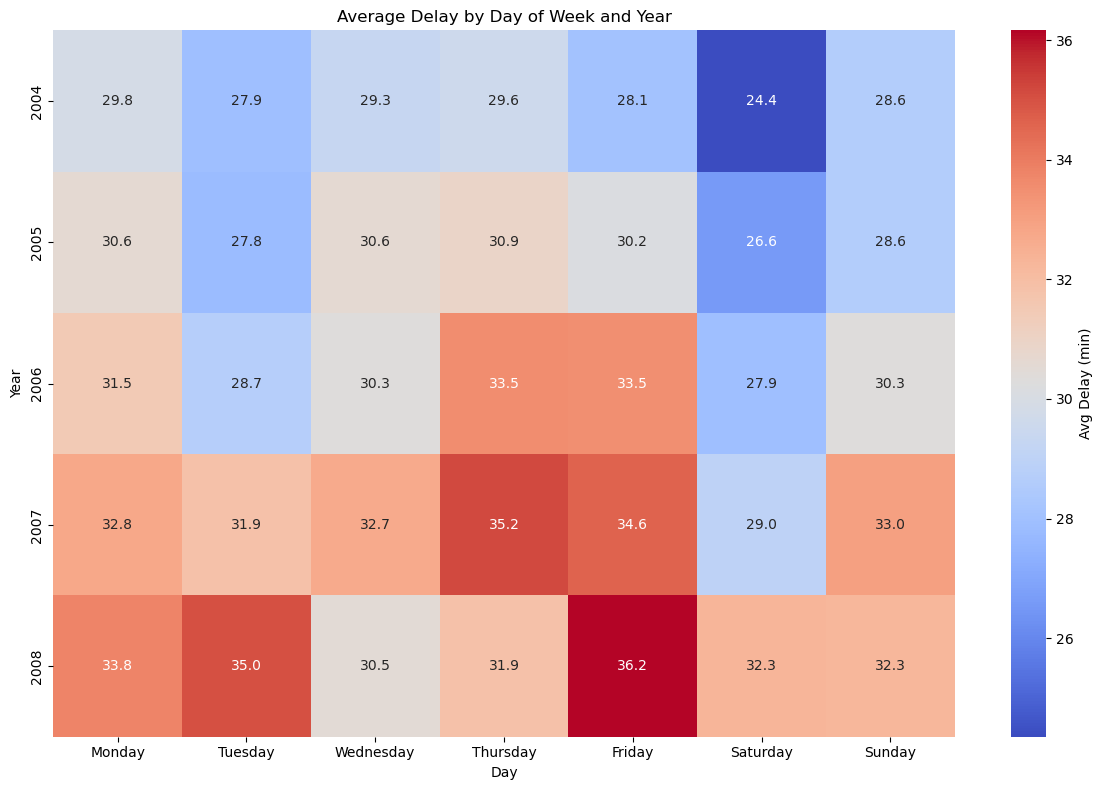

In [48]:
# Plot Day of Week Heatmap (Years vs Day of Week)
plot_delay_heatmap(
    data=Delays,
    row_var='Year',
    col_var='Day',
    row_order=sorted(Delays['Year'].unique()),
    col_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    plot_title='Average Delay by Day of Week and Year'
)

In [49]:
# Close the database connection
conn.close()

Part 2(b): Evaluate whether older planes suffer more delays on a year-to-year basis.

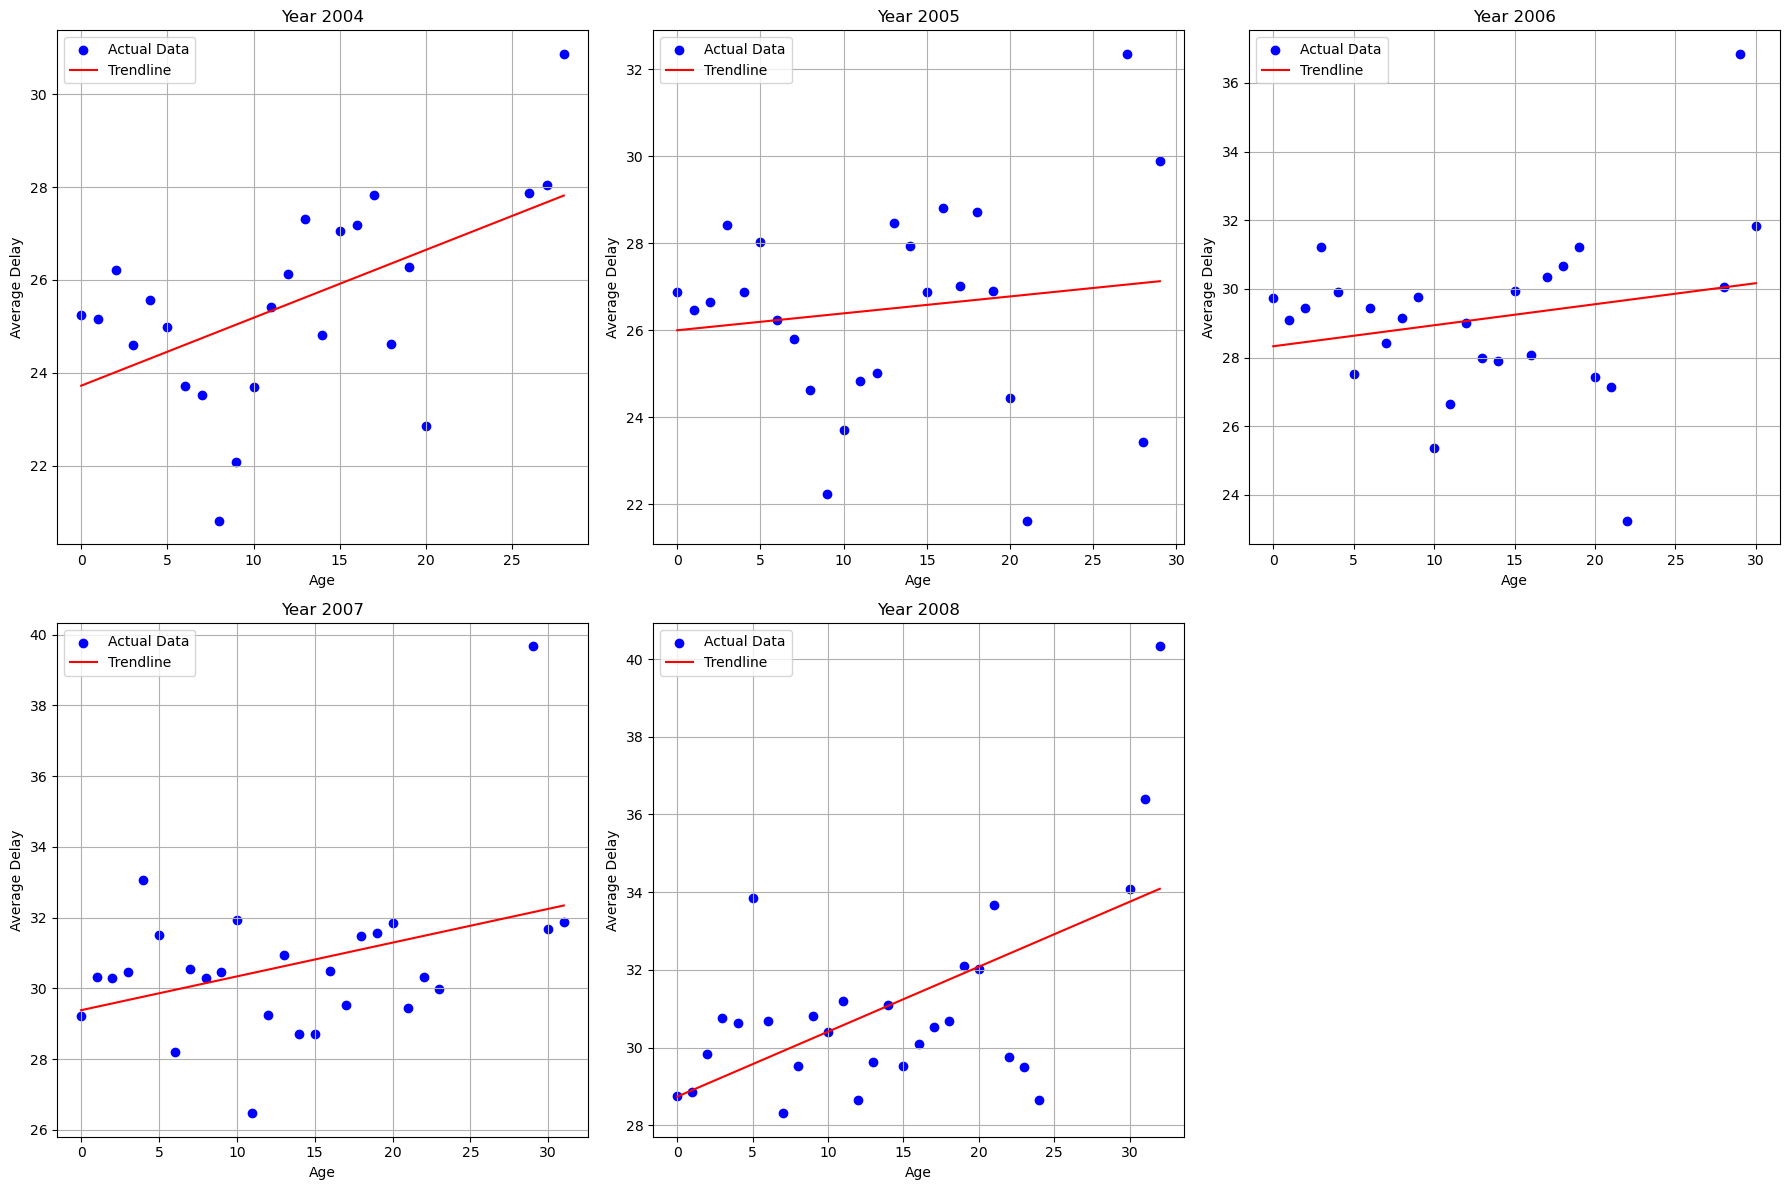

In [51]:
# Create a list containing every year
years = list(range(2004, 2009))

# Initialize an empty list to store plots and correlation results for part 2(b)
correlation_results = []

# Load the planes data only once
planes = pd.read_csv("plane-data.csv")

# Function to plot the data and fit a linear regression trendline
def plot_and_analyze(grouped, year, ax):
    ax.scatter(grouped['plane_age'], grouped['average_delay'], marker='o', color='b', label='Actual Data')

    # Perform linear regression
    X = grouped[['plane_age']]
    y = grouped['average_delay']
    model = LinearRegression().fit(X, y)
    trendline = model.predict(X)

    # Plot the trendline
    ax.plot(grouped['plane_age'], trendline, color='r', label='Trendline')
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Average Delay')
    ax.legend()
    ax.grid(True)

# Function to interpret correlation results
def interpret_correlation(correlation, year):
    if 0.87 < correlation <= 1:
        return f"A correlation coefficient of {correlation} indicates a strong positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are significantly more delays as the plane gets older in year {year}."
    elif 0.5 < correlation <= 0.87:
        return f"A correlation coefficient of {correlation} indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year {year}."
    elif 0 < correlation <= 0.5:
        return f"A correlation coefficient of {correlation} indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year {year}."
    elif -0.5 < correlation <= 0:
        return f"A correlation coefficient of {correlation} indicates a weak negative correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year {year}."
    elif -0.87 < correlation <= -0.5:
        return f"A correlation coefficient of {correlation} indicates a moderate negative correlation between age of the aircraft and average arrival delays. Hence, this shows that there are fewer delays as the plane gets older in year {year}."
    elif -1 < correlation <= -0.87:
        return f"A correlation coefficient of {correlation} indicates a strong negative correlation between age of the aircraft and average arrival delays. Hence, this shows that there are significantly fewer delays as the plane gets older in year {year}."
    return ""

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  
axes = axes.flatten() 

# Iterate over the first 5 years (2004–2008) to fit into the subplots
for i, year in enumerate(years):
    filename = f"{year}.csv.bz2"
    ontime = pd.read_csv(filename, compression='bz2', encoding='latin-1')

    # Filter relevant columns and rename them
    ontime = ontime[['TailNum', 'ArrDelay', 'Year']]
    ontime.columns = ['tailnum', 'ArrDelay', 'flight_year']
    
    # Merge once with planes data (avoiding repetitive merging)
    merged = pd.merge(ontime, planes[['tailnum', 'issue_date']], on='tailnum', how='right')
    
    # Drop rows with NA values
    merged = merged.dropna(subset=['issue_date', 'ArrDelay'])
    
    # Calculate the plane age
    merged['issue_date'] = pd.to_datetime(merged['issue_date'], format='%m/%d/%Y', errors='coerce')
    merged['issue_year'] = merged['issue_date'].dt.year
    merged['plane_age'] = merged['flight_year'] - merged['issue_year']

    # Filter out negative plane ages and negative ArrDelay values
    merged = merged[(merged['plane_age'] >= 0) & (merged['ArrDelay'] >= 0)]

    # Group by 'plane_age' and calculate average delay
    grouped = merged.groupby('plane_age').agg({'ArrDelay': 'mean'}).reset_index()
    grouped.columns = ['plane_age', 'average_delay']

    # Plot and analyze the data for each year in the subplot
    plot_and_analyze(grouped, year, axes[i])
    
    # Perform the correlation test
    correlation = scipy.stats.pearsonr(grouped['plane_age'], grouped['average_delay'])[0]
    correlation_results.append((year, correlation))

# Leave the last subplot empty by not plotting in it (the 6th subplot will be left out)
axes[5].axis('off')  

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plots
plt.show()

In [52]:
# Print the correlation results
for year, cor in correlation_results:
    print(interpret_correlation(cor, year))

A correlation coefficient of 0.5455586359652859 indicates a moderate positive correlation between age of the aircraft and average arrival delays. Hence, this shows that there are more delays as the plane gets older in year 2004.
A correlation coefficient of 0.1347208776849535 indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year 2005.
A correlation coefficient of 0.21540113155457888 indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year 2006.
A correlation coefficient of 0.37478344367879235 indicates a weak positive correlation between age of the aircraft and average arrival delays. Hence, this shows that delays remain relatively consistent even as the plane gets older in year 2007.
A correlation coefficient of 0.586791

Part 2(c): Logistic Regression Model

In [54]:
# Initialize an empty list to store results and plots for part 2(c)
results = []
plots = []

# Iterate over each year
for year in years:
    filename = f"{year}.csv.bz2"
    ontime = pd.read_csv(filename, compression = 'bz2', encoding = 'latin-1')

    # Extracting the hour from the scheduled departure and arrival times
    ontime['DepHour'] = ontime['CRSDepTime'].astype(str).str.zfill(4).apply(lambda x: str(x)[:2] if pd.notnull(x) else x)
    ontime['ArrHour'] = ontime['CRSArrTime'].astype(str).str.zfill(4).apply(lambda x: str(x)[:2] if pd.notnull(x) else x)

    # Merging the 'ontime' DataFrame with the 'airports' DataFrame based on the 'Origin' and 'Dest' columns to add latitude and longitude information for origin and destination airports
    ontime = pd.merge(ontime, airports, left_on='Origin', right_on='iata', how = 'left', suffixes=('', '_origin'))
    ontime = pd.merge(ontime, airports, left_on='Dest', right_on='iata', how = 'left', suffixes=('_origin', '_dest'))

    # Use LabelEncoder to convert categories to numeric values
    label_encoder = LabelEncoder()
    ontime['Origin'] = label_encoder.fit_transform(ontime['Origin'])
    ontime['Dest'] = label_encoder.fit_transform(ontime['Dest'])
    ontime['UniqueCarrier'] = label_encoder.fit_transform(ontime['UniqueCarrier'])

    # Extract variables needed to run the logistic regression model
    features = ontime[['Month', 'DayofMonth', 'DayOfWeek', 'DepHour', 'ArrHour', 'Origin', 'lat_origin', 'long_origin', 'Dest', 'lat_dest', 'long_dest', 'Distance', 'UniqueCarrier']].copy()
    target = ontime['Diverted']

    # Replace NA values with 0
    features.fillna(0, limit=1, inplace=True)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=100)

    # Initialize logistic regression model
    model = LogisticRegression(class_weight = "balanced", max_iter = 10000)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Extract coefficients
    coefficient = pd.DataFrame(model.coef_)
    variable = pd.DataFrame(X_train.columns.tolist())
    coeff_plot = pd.concat([variable,coefficient.T], axis=1)
    coeff_plot.columns = ['Variable', 'Coefficient']
    
    # Append results and plots to lists
    results.append((year, accuracy, conf_matrix))
    plots.append((year, coeff_plot))

In [55]:
# Print classification accuracy and confusion matrix
for year, accuracy, conf_matrix in results:
    print(f"Year {year}:\nAccuracy: {accuracy}\nConfusion Matrix:\n{conf_matrix}")

Year 2004:
Accuracy: 0.6403748209844766
Confusion Matrix:
[[911646 511420]
 [  1353   1435]]
Year 2005:
Accuracy: 0.6206894378623645
Confusion Matrix:
[[884863 540476]
 [  1225   1556]]
Year 2006:
Accuracy: 0.619914798881254
Confusion Matrix:
[[883581 541583]
 [  1325   1896]]
Year 2007:
Accuracy: 0.6237938929710198
Confusion Matrix:
[[927912 559332]
 [  1457   1942]]
Year 2008:
Accuracy: 0.6069888917722102
Confusion Matrix:
[[289393 187342]
 [   456    653]]


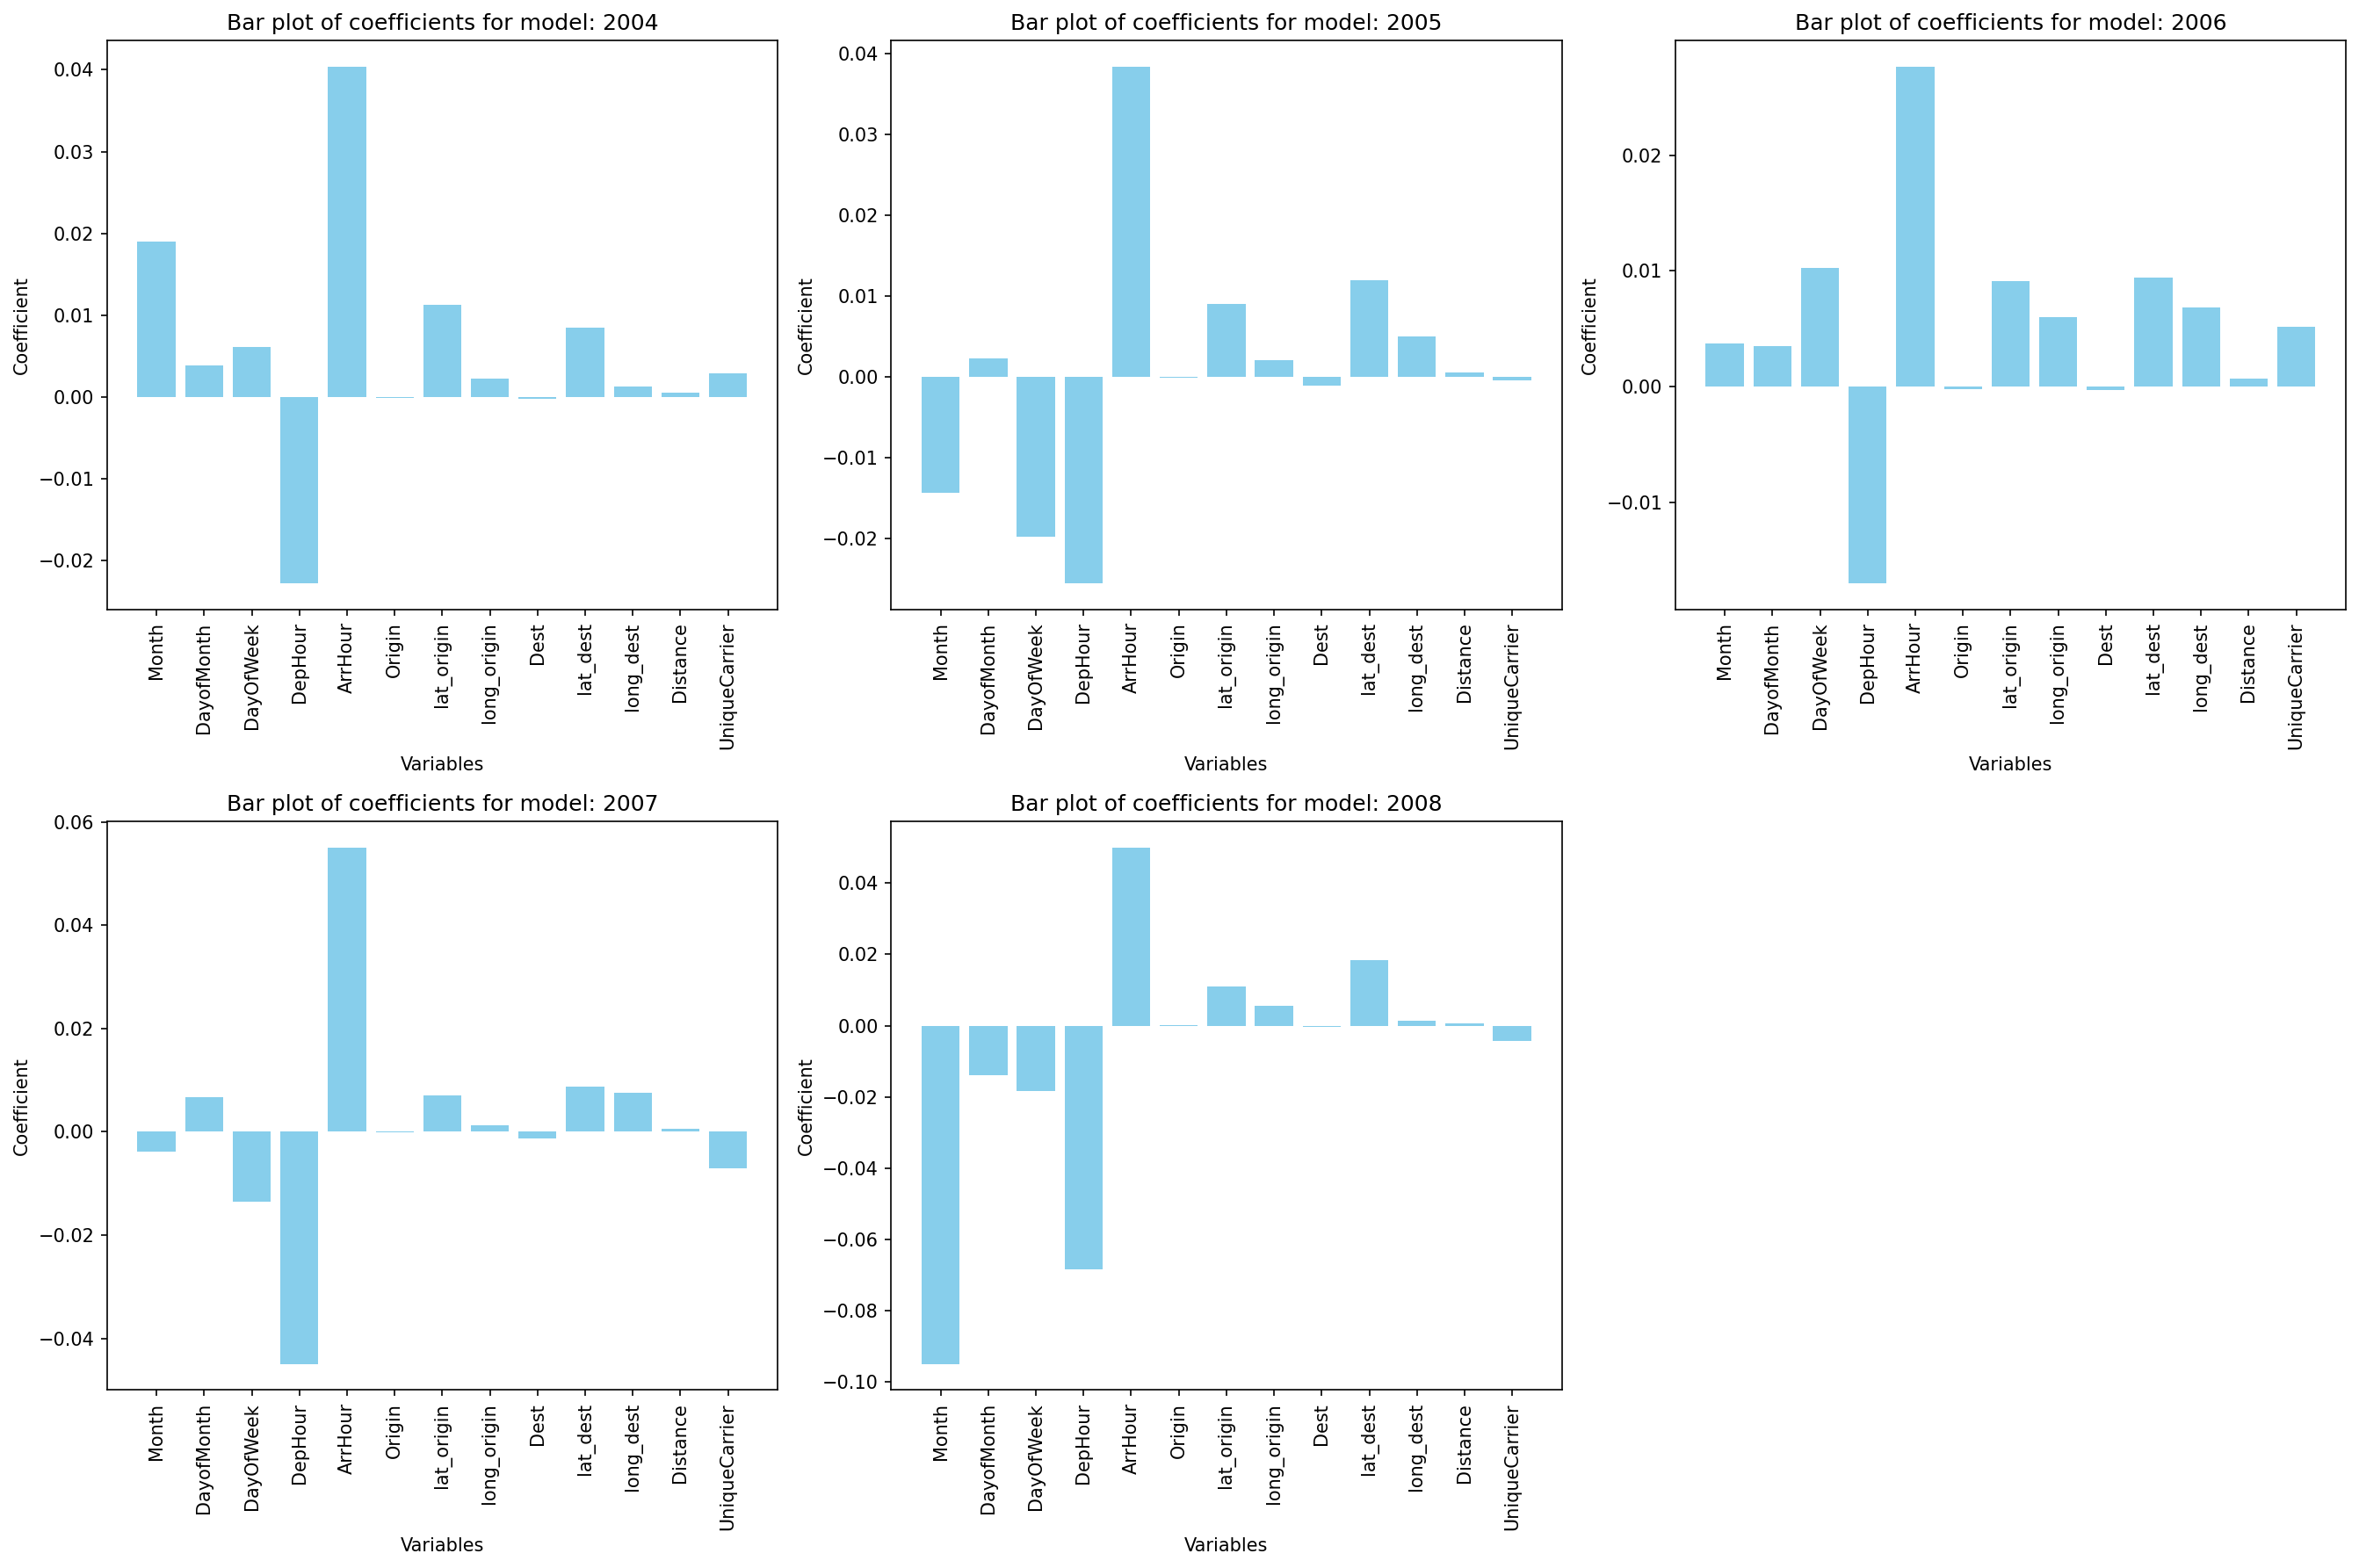

In [56]:
# Print the coefficient plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)  
axes = axes.flatten() 

# Iterate over each year and plot the coefficients
for i, (year, coeff_plot) in enumerate(plots):
    ax = axes[i]
    ax.bar(coeff_plot['Variable'], coeff_plot['Coefficient'], color='skyblue')
    ax.set_xticks(coeff_plot['Variable'])
    ax.set_xticklabels(coeff_plot['Variable'], rotation=90)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Coefficient')
    ax.set_title(f'Bar plot of coefficients for model: {year}')

# Hide any extra empty subplots (in case there are less than 6 plots)
for j in range(len(plots), len(axes)):
    axes[j].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()